In [1]:
%matplotlib notebook

from forced_barotropic_sphere.sphere import Sphere
from forced_barotropic_sphere.solver import Solver
from forced_barotropic_sphere.forcing import Forcing
import forced_barotropic_sphere.parcel_tracking as tracking
import forced_barotropic_sphere.plotting as plotters
import forced_barotropic_sphere.ensemble_methods as ensemble_methods


import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl          # Plotting routines
import matplotlib.pyplot as plt    
import matplotlib.animation as manim
import matplotlib.ticker as mticker
from IPython.display import display, clear_output, HTML, FileLink  # Some technical stuff, used to display animation
#from ipywidgets import FloatProgress
from ipykernel.pylab.backend_inline import flush_figures
import cartopy                   # Map projection stuff
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

/home/bertossa/miniconda3/envs/jupyter/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
##physical constants
s2d = 1/3600/24    # seconds to days
s2h = 1/3600       # seconds to hours
a = 6371e3         # Radius of the earth in m
g00 = 9.81         # Acceleration due to gravity near the surface of the earth in m/s^2
R = 287.           # Dry gas constant in J/K/kg
d2r = np.pi / 180. # Factor to convert degrees to radians
r2d = 180. / np.pi # Factor to convert radians to degrees


In [3]:
num_members= 10 #num of members in the ensemble
dt = 4000 #time between integration steps (seconds)
Nt = 400 #number of integration steps
T= Nt*dt #total integration time

print('integrating for {:.1f} days with a dt of {:.2f} hours'.format(T*s2d,dt*s2h))

ofreq = 6 #frequency of integration output in resulting ds
print('output freq of {:.2f} hours'.format(dt*s2h*ofreq))

ofreq = 6

#T42 resolution
nlat=64; nlon=128

thetap = np.zeros((nlat,nlon))
vortp = np.zeros((nlat,nlon))
ics = np.array([vortp,thetap])

ensemble = ensemble_methods.integrate_ensemble(nlat,nlon,dt=dt, T=T, ofreq=ofreq, ics=ics,
                                                n_ens=num_members, temp_linear=True,
                                               vort_linear=True)
ensemble=ensemble.assign_coords(ens_mem= range(len(ensemble.ens_mem)))
tidx=int(Nt/ofreq)-1

# f,axs=plotters.plot_ensemble_overview(ensemble.isel(time=tidx), perturbation=[True,False],
#                                       levels=[np.linspace(-1,1,6),np.arange(258,300,7),None])


integrating for 18.5 days with a dt of 1.11 hours
output freq of 6.67 hours


100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.16s/it]


In [4]:
dsr = ensemble.rename(dict(x='lon',y='lat'))
# Reassign longitude coordinates between -180 and 180E
dsr = dsr.assign_coords(lon=(((dsr.lon + 180) % 360) - 180))
dsr = dsr.sortby('lon')
dsr=dsr.reindex(lat=list(reversed(dsr.lat)))

#x0 should be in form [(lon,lat),]
std = dsr.theta.std('ens_mem').sel(lat=slice(30,90))
sm = std.where(std==std.max(), drop=True).squeeze()
x0 = [(sm.lon.item(0),sm.lat.item(0))]

ts, xs = tracking.ens_calculate_trajectories(dsr, x0, t0 = float(T), rvs=True)


Integrating 1 trajectories for [18.51851852].


100%|█████████████████████████████████████████| 329/329 [09:13<00:00,  1.68s/it]

Completed 330 of 330 timesteps.


<IPython.core.display.Javascript object>


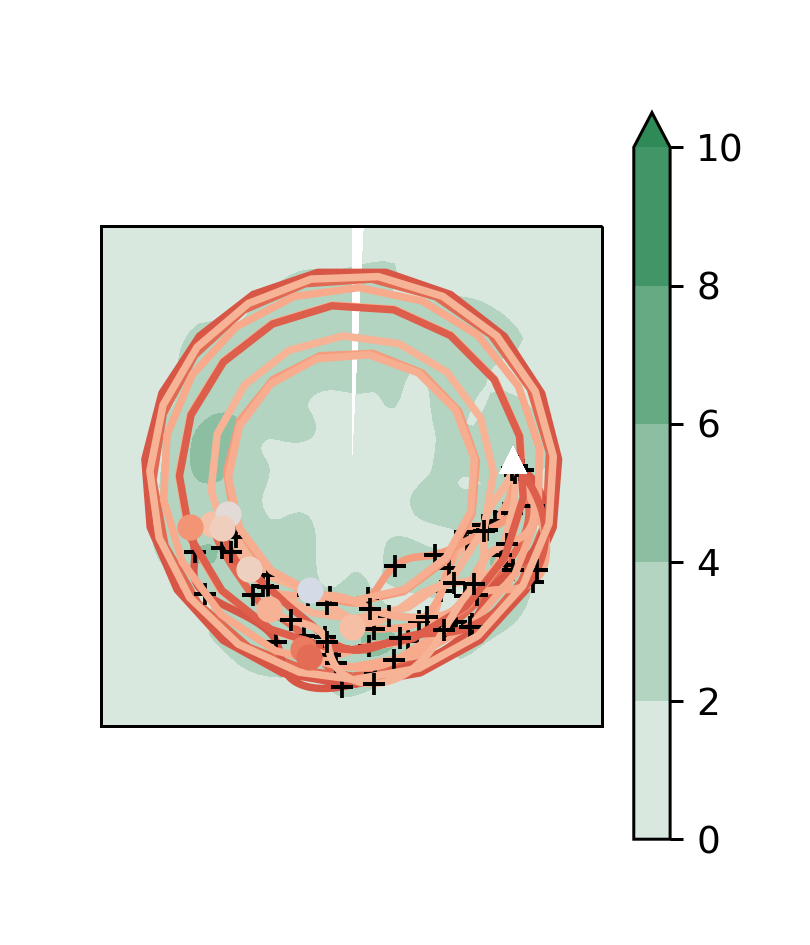

277.155769821523
283.62790310952846
277.6410982506597
281.7534830820367
284.6970723897894
271.33037121314425
273.13465452642015
275.1154262112923
275.4787761766016
278.96246370794006


In [9]:
f = plt.figure(3, figsize = (3, 3.5), dpi = 200)
f.clf()
ax = plt.subplot(1, 1, 1, projection = ccrs.NorthPolarStereo())
ax.set_extent([-179.9, 179.9, 20, 90], crs=ccrs.PlateCarree())
import seaborn as sns

cm = sns.color_palette("light:seagreen", as_cmap=True)
    #ax=plotters.plot_theta_ensspread(ensemble.sel(time=T), levels=np.arange(0,8,1))
cf=ax.contourf(dsr.lon,dsr.lat, dsr.theta.std('ens_mem').sel(time=T).data,
            cmap=cm, levels=np.arange(0,12,2),transform=ccrs.PlateCarree(), extend='max')
plt.colorbar(cf)
norm = plt.Normalize(255, 290)
cmap = plt.cm.coolwarm

# ax.contour(ensemble.x,ensemble.y,ensemble.sel(time=0).sel(ens_mem=0).theta,
#            cmap=cmap, levels=np.arange(250,305,5), transform=ccrs.PlateCarree(),zorder=10)
trjs = xs
ntr = trjs.shape[2]



for i in range(ntr):
    col = dsr.theta.sel(ens_mem=i).interp(time=T, lon=xs[0,0,i],lat=xs[0,1,i]).item(0)
    ax.plot(np.mod(trjs[:, 0, i],360), trjs[:, 1, i], c=cmap(norm(col)), lw=2., transform=ccrs.PlateCarree())
    ax.plot(np.mod(trjs[7::50, 0, i],360), trjs[7::50, 1, i], 'k+', ls='', mew=1., transform=ccrs.PlateCarree())
    ax.plot(trjs[0:1, 0, i], trjs[0:1, 1, i], 'w^', ls='', mew=1, transform=ccrs.PlateCarree(),zorder=100)
    
    col = dsr.theta.sel(ens_mem=i).interp(time=0, lon=trjs[-1,0,i],lat=trjs[-1,1,i]).item(0)
    print(col)
    ax.scatter(np.mod(trjs[-1, 0, i],360), trjs[-1, 1, i], c= col, norm=norm,cmap=cmap,
             transform=ccrs.PlateCarree(), zorder=10)
plt.show()
#careful..producing the animation takes a bit.        
#plotters.animate_thetaens(dsr,times = [0,T],xs=xs,ts=ts)        

<IPython.core.display.Javascript object>


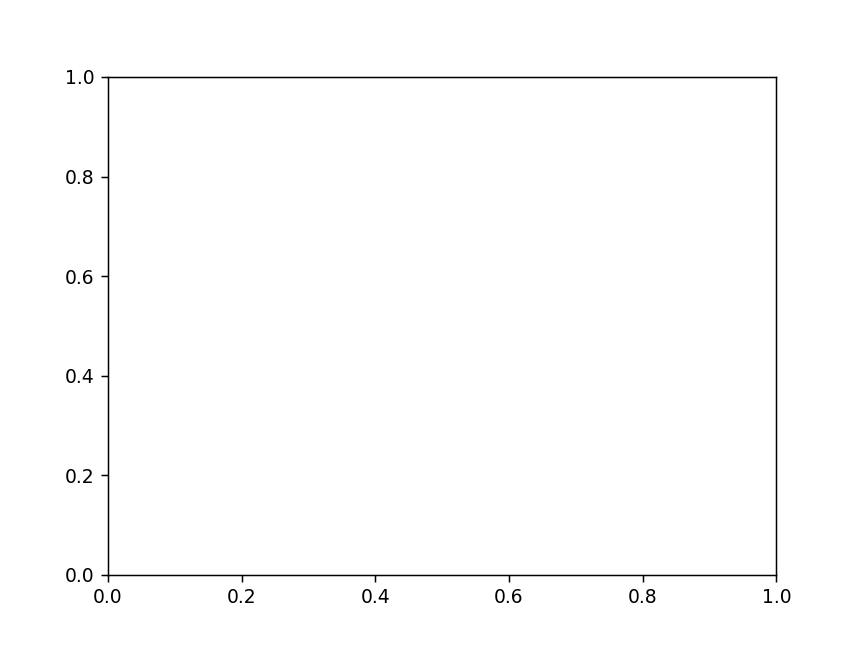

MovieWriter ffmpeg unavailable; using Pillow instead.


In [5]:
plt.cla()
plotters.animate_thetaens(dsr,times = [0,T],xs=xs,ts=ts, tlevs=np.arange(0,9,1))

In [18]:
import xarray as xr
import seaborn as sns
def animate_thetaens(ds, times, xs, ts=None, tlevs = np.arange(0,12,2),
                     filename = 'espread.gif', step=3600*2, mod=False):
    """
    animate spread of theta, include trajectories as well if desired
    """
    
    dt=step
    frames = np.arange(times[0], times[1], dt)
    
    if times[0] < ds.time.data[0] or times[1] > ds.time.data[-1]:
        raise ValueError('You are trying to animate a time period '
                        'there is no data for.')
    skip = 3
        
    plt.ioff()
    f = plt.figure(3, figsize = (5, 3.5), dpi = 150)
    f.clf()
    ax = plt.subplot(1, 1, 1, projection = ccrs.NorthPolarStereo())
    ax.set_extent([-179.9, 179.9, 20, 90], crs=ccrs.PlateCarree())

    plotters.make_ax_circular(ax)
    
    ds=xr.concat([ds, ds.isel(lon=slice(0,1)).assign_coords(lon=[180])], dim='lon')
    background = ds.theta.sel(ens_mem=0).sel(time=0)
    theta = ds.theta.std('ens_mem')
    
    #use to get colorbar
    cm = sns.color_palette("light:seagreen", as_cmap=True)
    normcm = mpl.colors.BoundaryNorm(tlevs, cm.N)

    cf=ax.contourf(theta.lon.data, theta.lat.data, theta.interp(time=times[1]).data, transform = ccrs.PlateCarree(), 
            levels=tlevs,cmap=cm, norm=normcm)
    
    plt.colorbar(cf, ax=ax, label='Std(Temp) (K)',shrink=0.8)
    Ntraj = xs.shape[2]
    
    btlev= np.arange(260,300,5)
    norm = plt.Normalize(btlev[0], btlev[-1])
    cmap = plt.cm.coolwarm
    
    ax.contour(background.lon.data, background.lat.data, background.data,
           cmap=cmap, levels=btlev, transform=ccrs.PlateCarree(),linestyles='--', alpha=0.75,zorder=10)
        
    
    def anim(t):
        if (t/step)%10==0:
            print('animating {:d} of {:d} frames'.format(t//step,len(frames)))
        
        plt.ioff()
        ax.cla()
        plotters.make_ax_circular(ax)
        ax.set_extent([-179.9, 179.9, 20, 90], crs=ccrs.PlateCarree())
        
        cf=ax.contourf(theta.lon,theta.lat, theta.interp(time=t).data, transform = ccrs.PlateCarree(), 
                    cmap=cm, levels=tlevs,norm=normcm)
        
        ax.contour(background.lon.data, background.lat.data, background.data,
           cmap=cmap, levels=btlev, transform=ccrs.PlateCarree(),zorder=10,linestyles='--', alpha=0.75)
        
        title = '{:.2f} days'.format(t*s2d)
        
        # Set the plot title
        ax.set_title(title, fontsize=9)
        for i in range(Ntraj):
            ind = np.where(ts[:, i] < t)[0]

            if len(ind) > 0:
                #cols = ds.theta.sel(ens_mem=i).interp(time=ts[50::100,i], lon=xs[50::100, 0, i] ,  lat=xs[50::100, 1, i]).values
            
                #ax.plot( xs[50::100, 0, i] ,  xs[50::100, 1, i],   c=cmap(norm(cols)), lw=0., marker='o', transform = ccrs.PlateCarree(),)
            
                col = ds.theta.sel(ens_mem=i).interp(time=t, lon=xs[ind[-1],0,i], lat=xs[ind[-1],1,i]).item(0)

                ax.plot( plotters.sanitize_lonlist(xs[ind      , 0, i]) ,  xs[ind      , 1, i],
                        c=cmap(norm(col)), lw=2., transform = ccrs.PlateCarree(),)
                ax.plot( xs[ind      , 0, i] ,  xs[ind      , 1, i],  c=cmap(norm(col)), lw=2.,
                        transform = ccrs.PlateCarree(),zorder=20)
                ax.plot([xs[ind[0]   , 0, i]], [xs[ind[0]   , 1, i]], 'kx', zorder=20,transform = ccrs.PlateCarree(),)
                #ax.plot( xs[ind[25::50], 0, i] ,  xs[ind[25::50], 1, i],  'k+', transform = ccrs.PlateCarree(),)

                if len(ind) < ts.shape[0]:
                    #initial point
                    col = ds.theta.sel(ens_mem=i).interp(time=0, lon=xs[-1,0,i],lat=xs[-1,1,i]).item(0)

                    ax.scatter([xs[ind[-1]  , 0, i]], [xs[ind[-1]  , 1, i]], c= col, norm=norm, cmap=cmap,
                     transform=ccrs.PlateCarree(), zorder=30)

        plt.ion()
        plt.draw()

    anim = manim.FuncAnimation(f, anim, frames, repeat=False)
    
    anim.save(filename, fps=12, codec='h264', dpi=150)
    plt.ion()
animate_thetaens(dsr,times = [0,T],xs=xs,ts=ts, tlevs=np.arange(0,9,1))

MovieWriter ffmpeg unavailable; using Pillow instead.


animating 0 of 223 frames
animating 0 of 223 frames
animating 10 of 223 frames
animating 20 of 223 frames
animating 30 of 223 frames
animating 40 of 223 frames
animating 50 of 223 frames
animating 60 of 223 frames
animating 70 of 223 frames
animating 80 of 223 frames
animating 90 of 223 frames
animating 100 of 223 frames
animating 110 of 223 frames
animating 120 of 223 frames
animating 130 of 223 frames
animating 140 of 223 frames
animating 150 of 223 frames
animating 160 of 223 frames
animating 170 of 223 frames
animating 180 of 223 frames
animating 190 of 223 frames
animating 200 of 223 frames
animating 210 of 223 frames
animating 220 of 223 frames


In [19]:
def sanitize_lonlist(lons):
    """
    This fixes an issue when moving across meridians with line plots 
    """
    lons = np.array(lons)
    diffs = np.diff(lons)
    wraploc = np.where(abs(diffs)>30)[0]+1
    #for ii in wraploc:
    if len(wraploc)>0:
        if lons[0]>0: #goes from 180 -> -180
            lons[wraploc[0]:]+=360
        else: #goes form -180 -> 180
            lons[wraploc[0]:]-=360
        
    return lons    
    

In [14]:
plt.cla()